# Effect of varying the smoothing factor

In [1]:
import pymultieis as pym
import numpy as np
import torch

In [2]:
# Load the file containing the frequencies
F_her = torch.as_tensor(np.load('../../../data/her_50/freq_50.npy'))
# Load the file containing the admittances (a set of 50 spectra)
Y_her = torch.as_tensor(np.load('../../../data/her_50/Y_50.npy'))


In [3]:
print(F_her.shape)
print(Y_her.shape)

torch.Size([35])
torch.Size([35, 50])


In [4]:
# Define model
def her(p, f):
    w = 2*torch.pi*f
    s = 1j * w  
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rad = p[3]
    Cad= p[4]
    nad= p[5]
    Rct= p[6]
    Wct=p[7] 
    Zw = Wct/torch.sqrt(w) * (1-1j)
    Zct   = Rad + Zw  
    Yca=(((s**nad)*Cad) + Rct**-1)
    Z1=(Yca**-1 +Zct)
    Y1=(Z1**-1)
    Ydl= ((s**nh)*Qh)
    Z = (Rs + (Ydl + Y1)**-1) 
    Y = 1/Z
    return torch.cat((Y.real, Y.imag), dim = 0)

In [5]:
p0 = torch.as_tensor([4.72774187e+02, 9.70785283e-07, 6.51261304e-01,
             1.04825669e+03, 7.27786796e-07, 8.33955442e-01,
             5.98926963e+04, 2.03231984e+04], dtype=torch.float64)

bounds = [[1e-3,  1e6], [1e-9, 1e-1], [1e-1, 1], [1e-5, 1e8], [1e-9,  1e-1], [1e-1, 1], [1e-5,  1e8], [1e-5,  1e8]]


smf_modulus = torch.ones(len(p0)) # Smoothing factor used with the modulus

## 1. Fit simultaneous without a smoothing factor of zero


Using initial
Iteration : 627, Loss : 6.41679e-04
Optimization complete
total time is 0:00:31.584263 

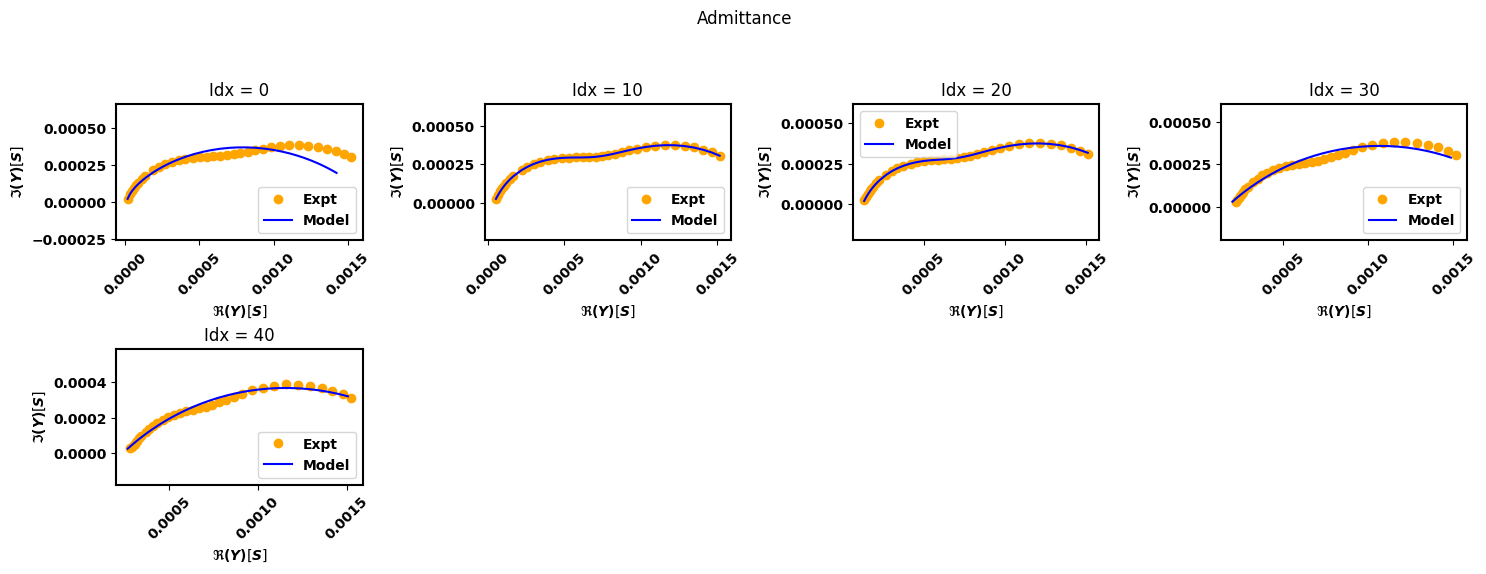

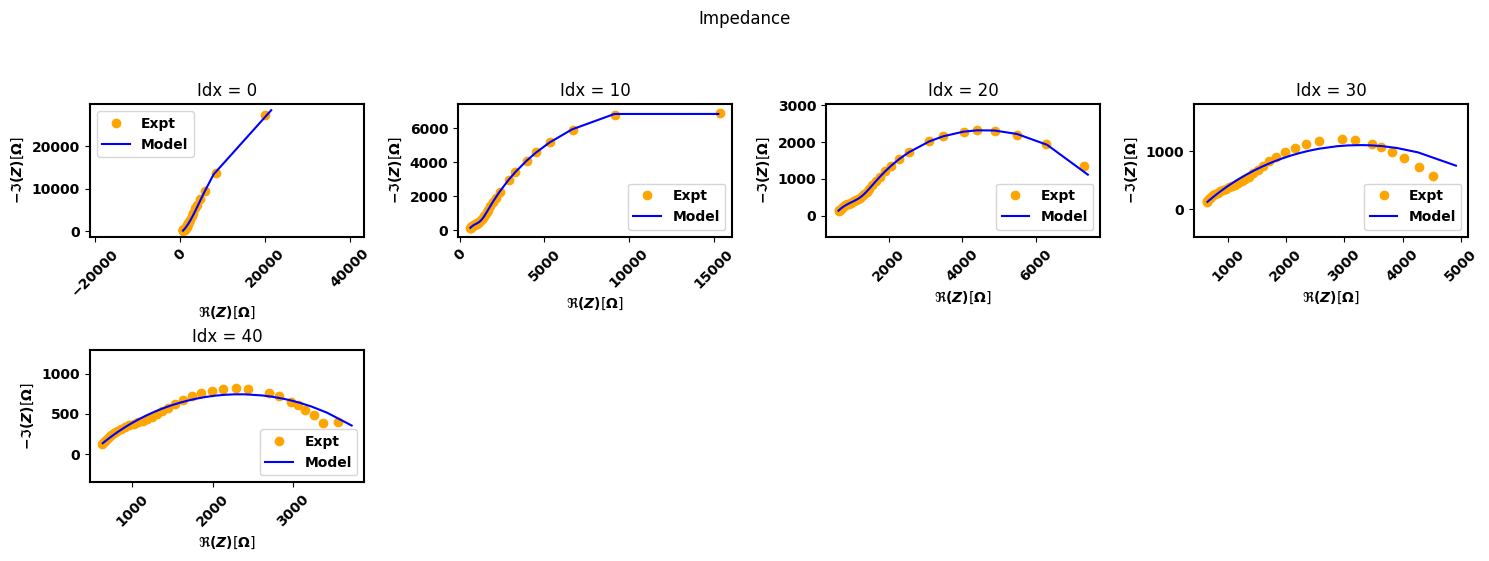

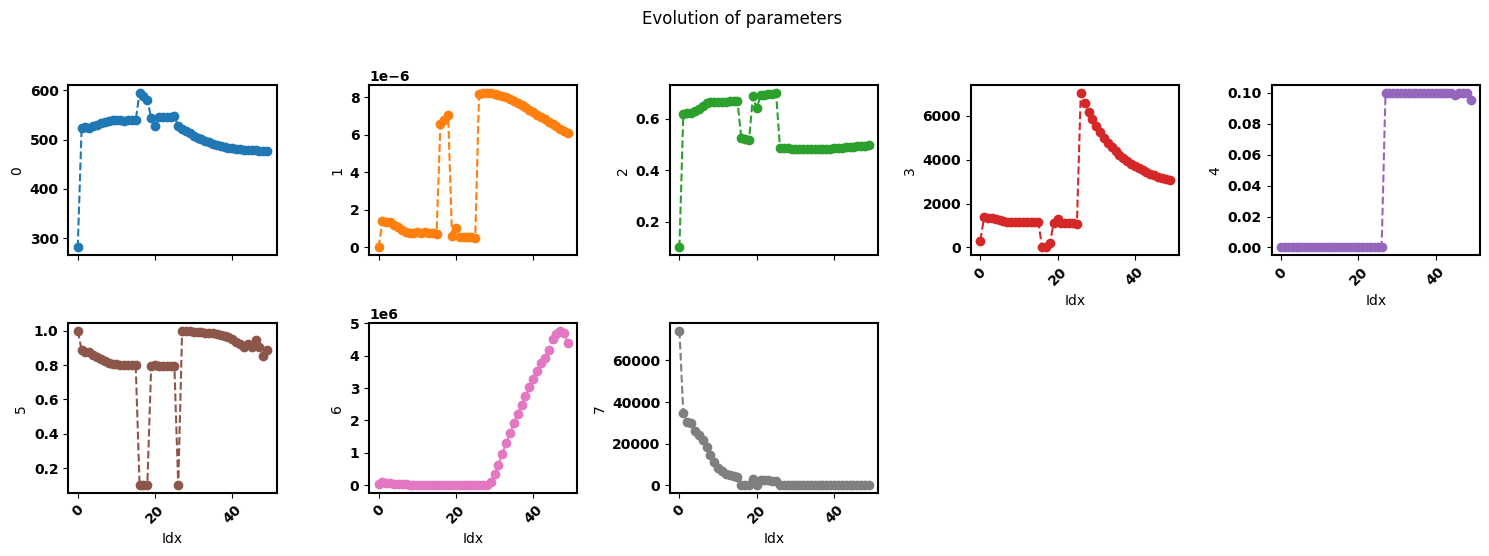

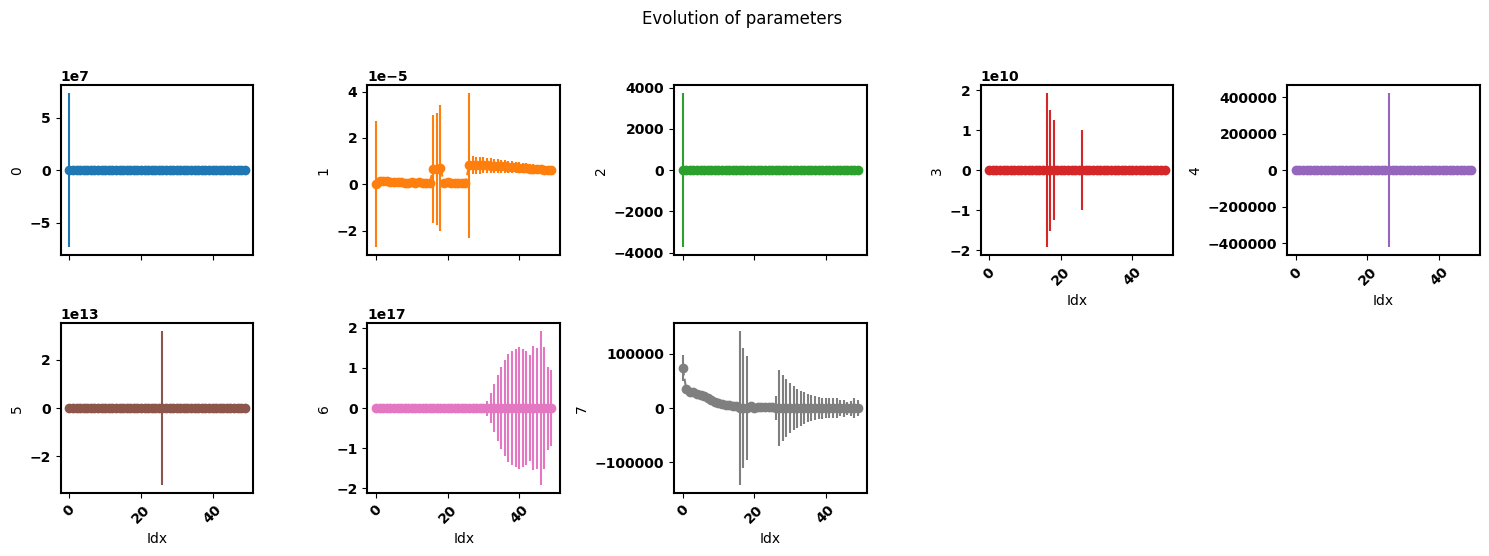

In [6]:
eis_her = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous_zero()
eis_her.plot_nyquist(10)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)

## 2. Fit sequential (i.e. fit individual spectra using least squares)


Using initial
fitting spectra 0
fitting spectra 10
fitting spectra 20
fitting spectra 30
fitting spectra 40

Optimization complete
total time is 0:00:22.454748 

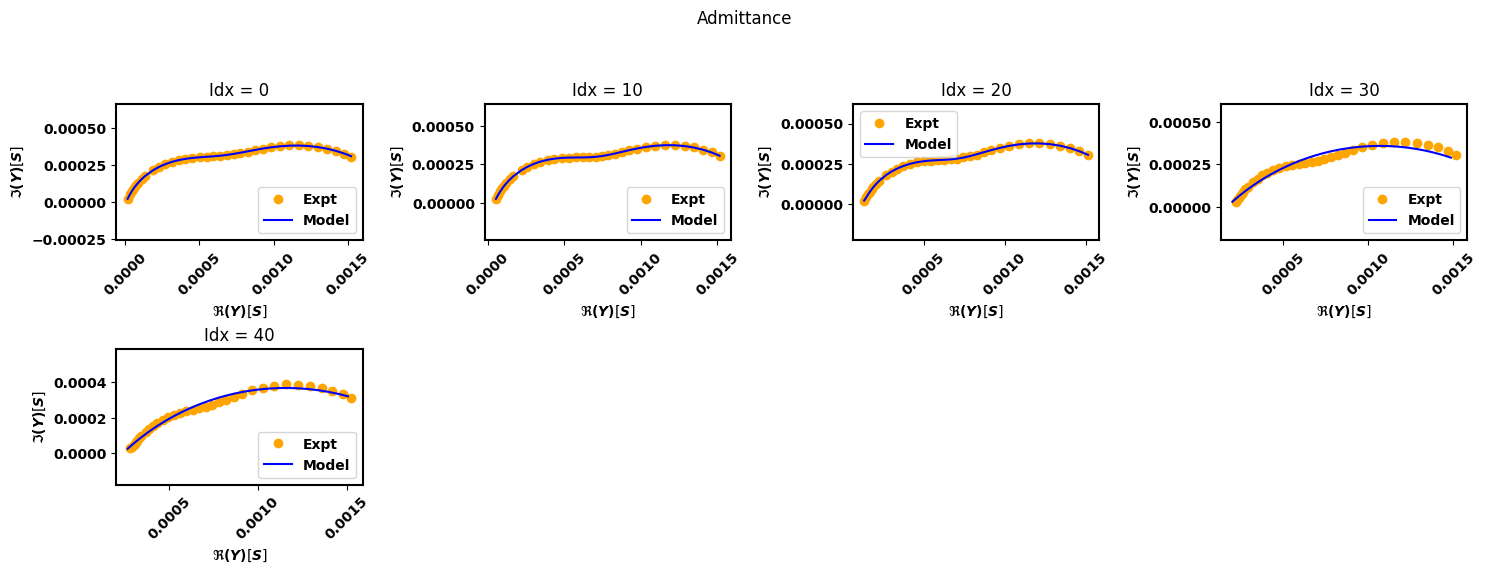

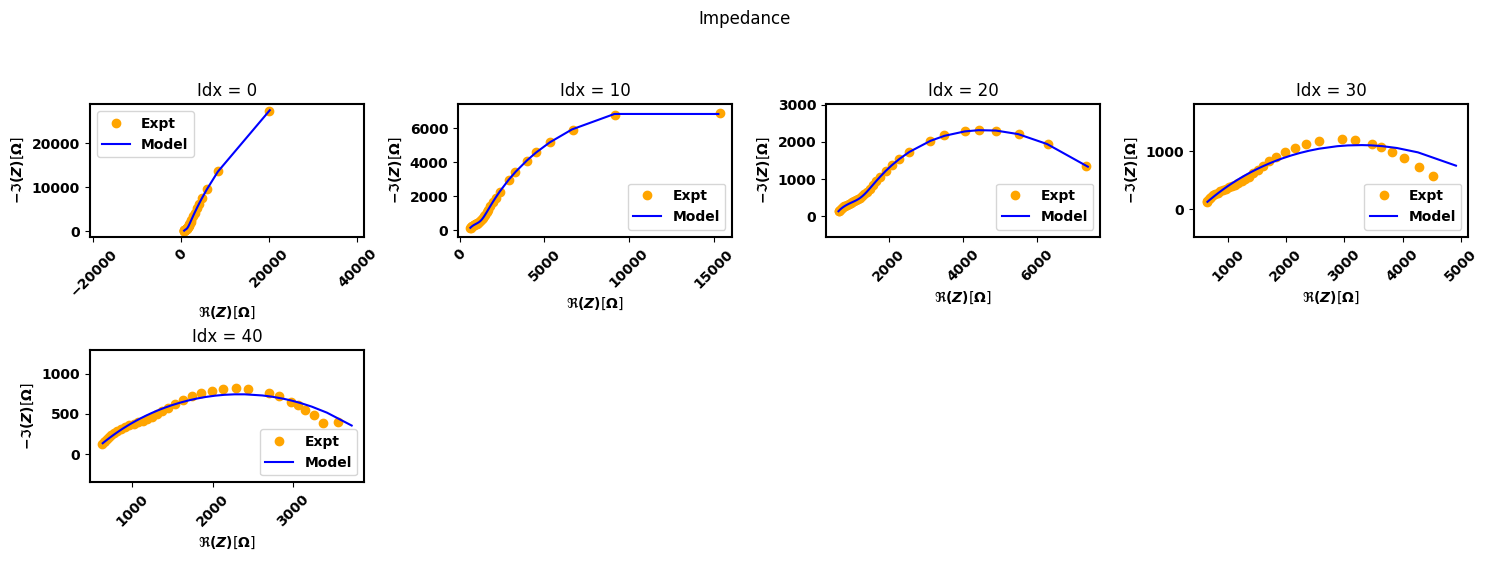

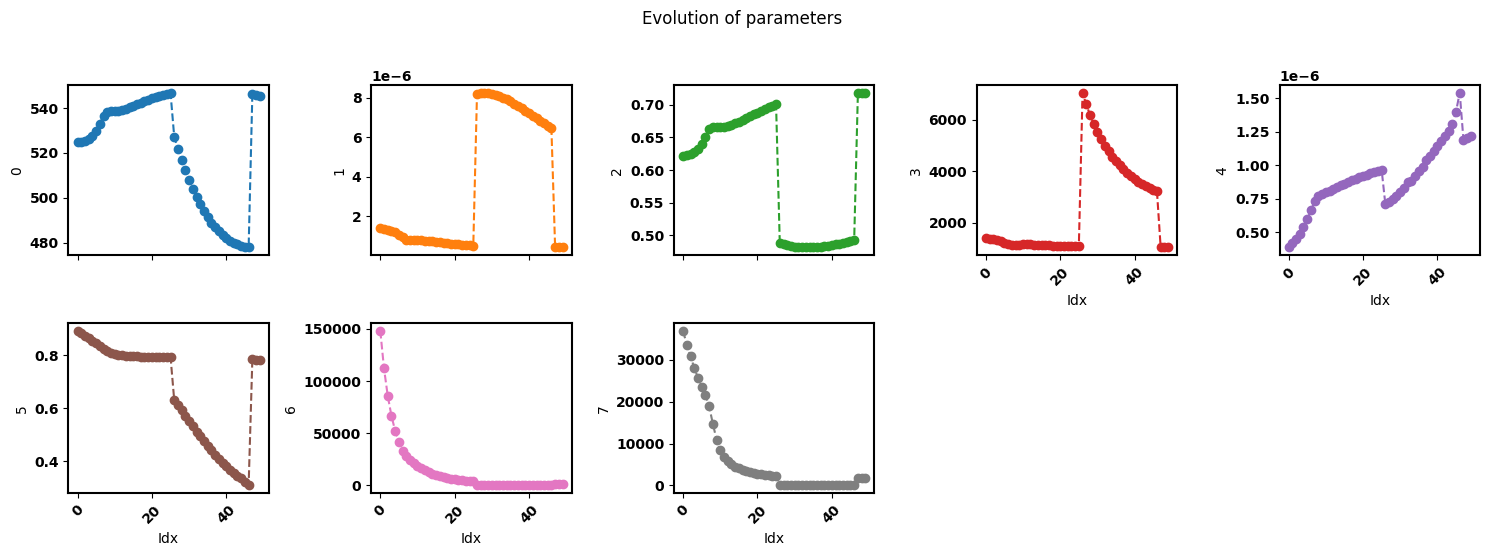

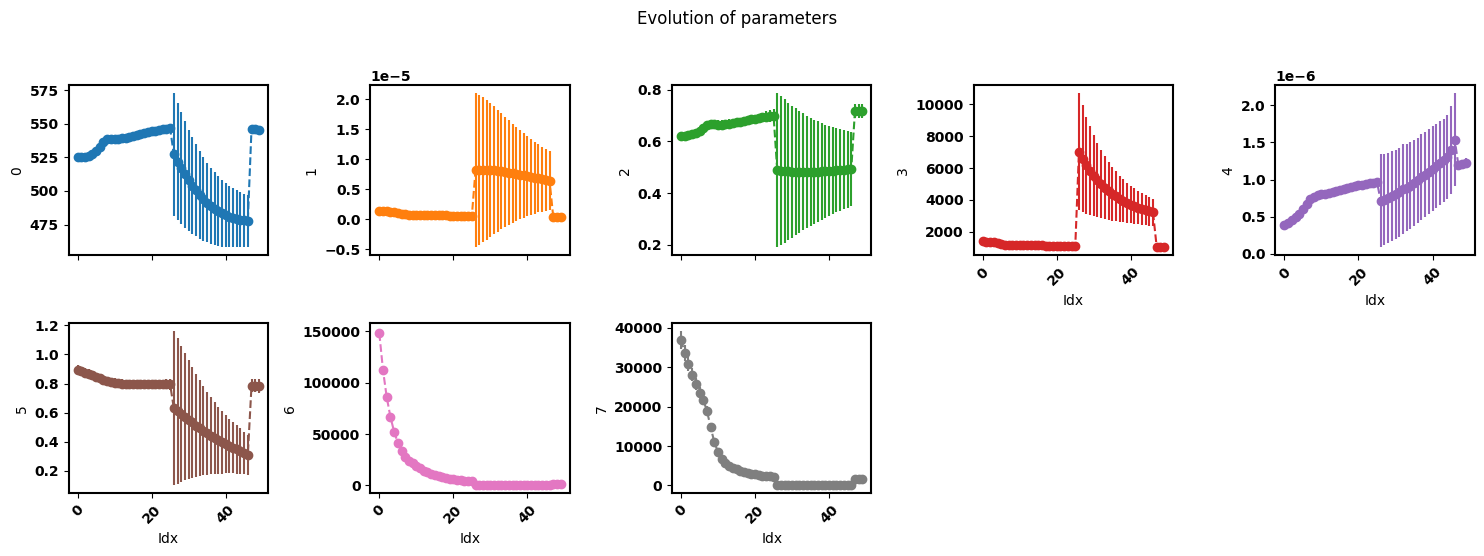

In [7]:
eis_her = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her.fit_sequential()
eis_her.plot_nyquist(10)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)

## 3. Use a smoothing factor to obtain reasonable initial values before setting the smoothing factor to zero


Using initial
Iteration : 0, Loss : 5.45579e-02
Iteration : 1000, Loss : 1.85335e-04
Iteration : 2000, Loss : 4.10082e-05
Iteration : 3000, Loss : 7.90959e-06
Iteration : 3849, Loss : 4.88181e-06
Optimization complete
total time is 0:00:38.307650
 
Using prefit
Iteration : 317, Loss : 4.54904e-06
Optimization complete
total time is 0:00:09.939451 

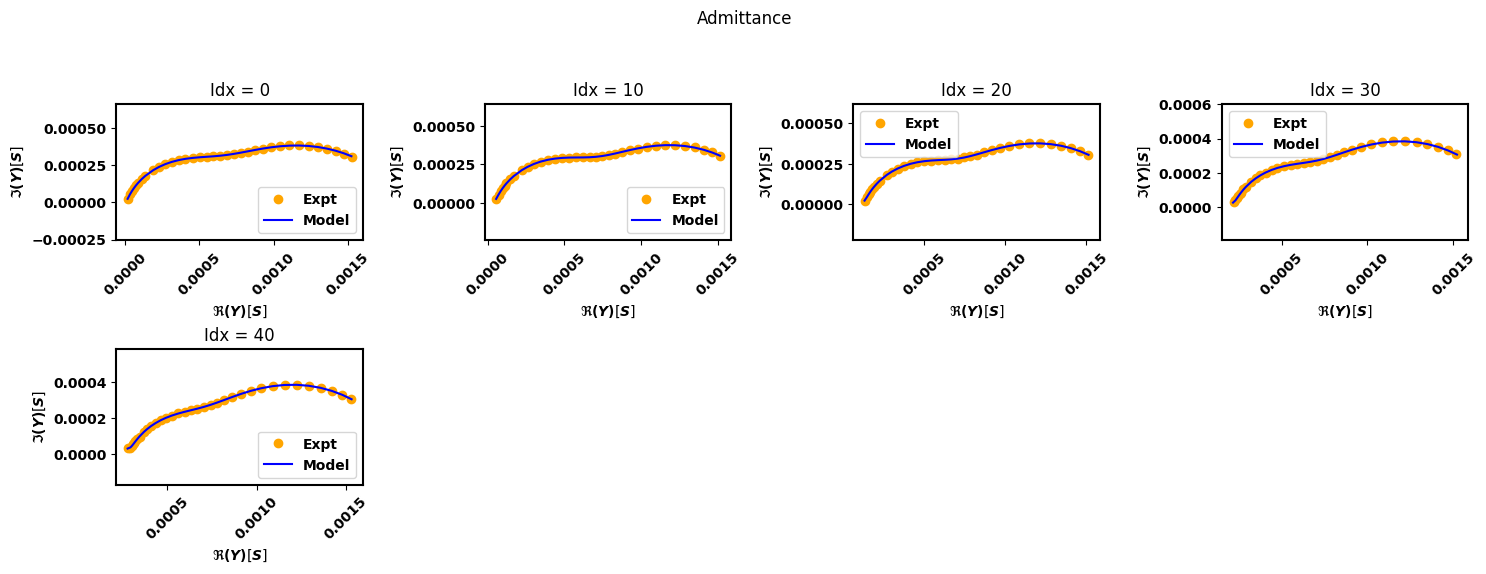

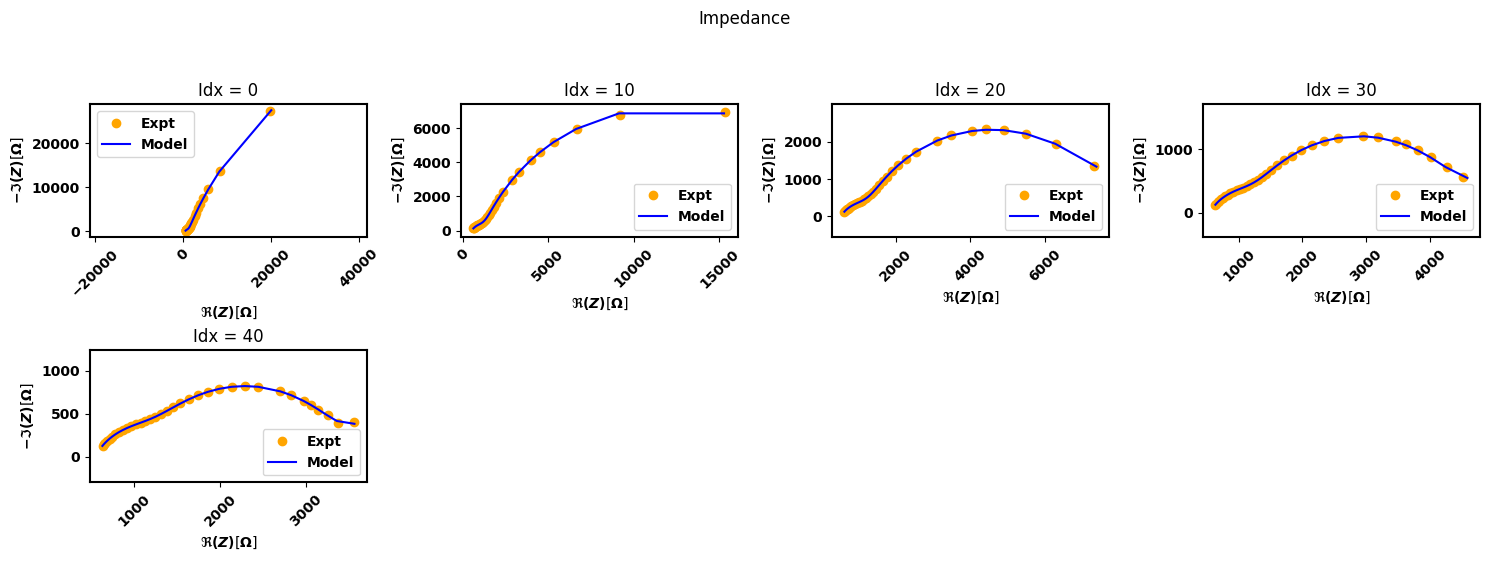

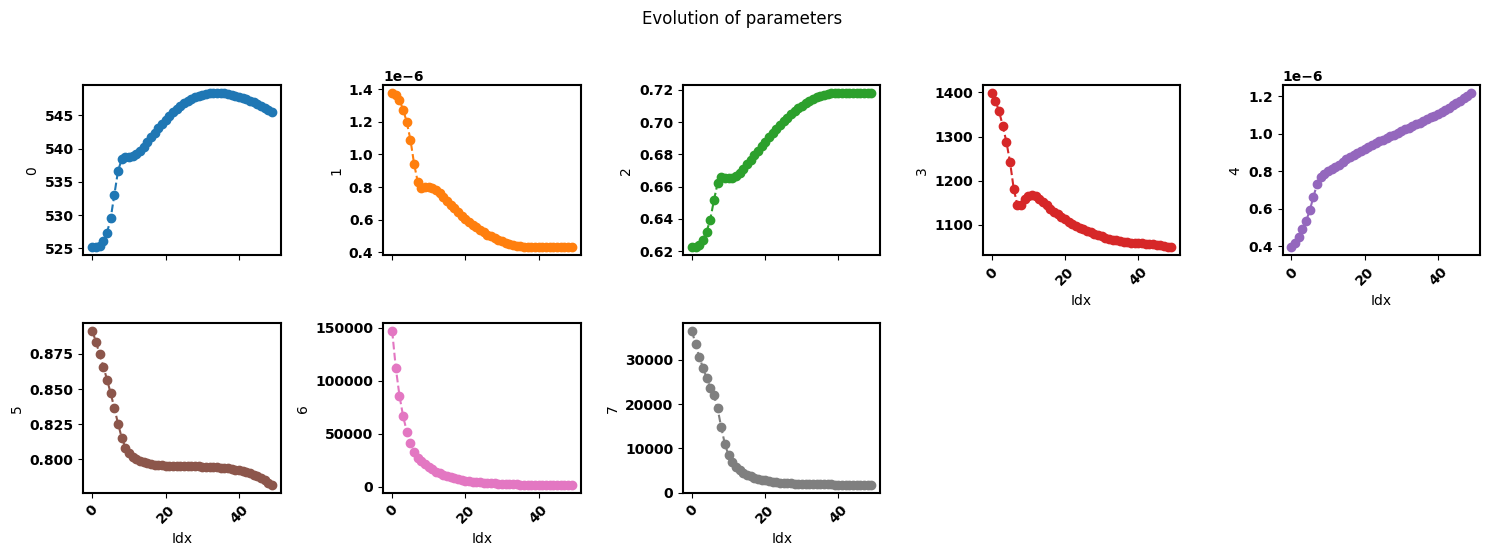

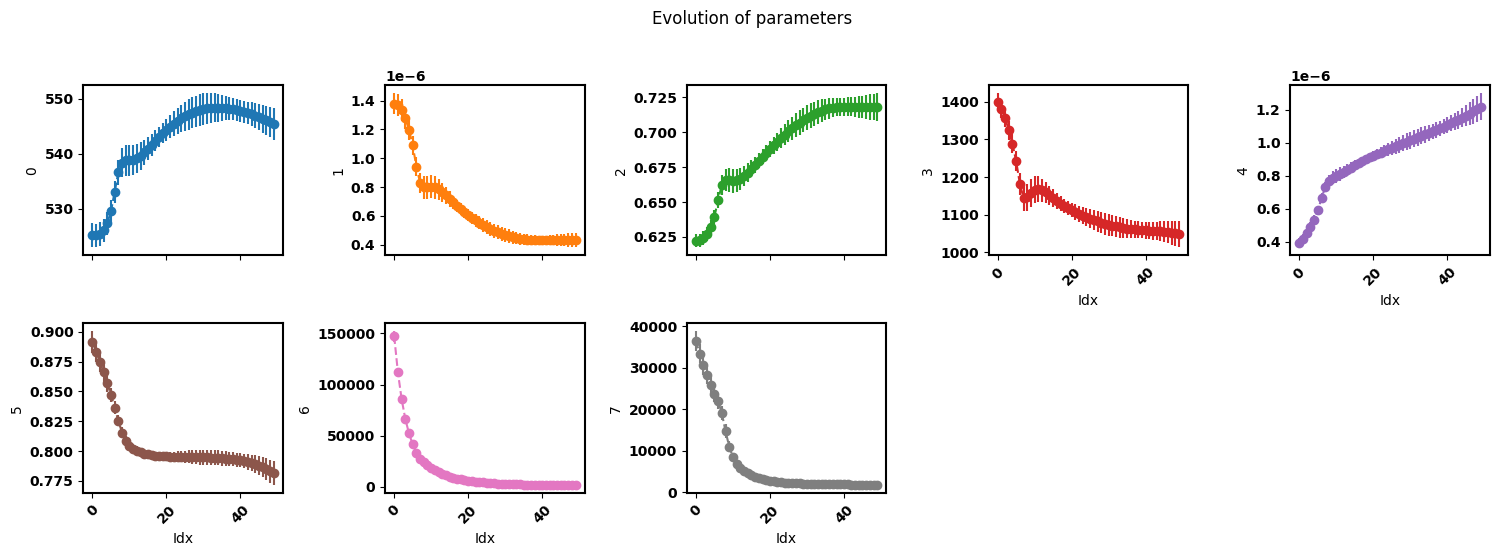

In [8]:
eis_her = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous(method='l-bfgs-b')
popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous_zero()
eis_her.plot_nyquist(10)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)

## 4. Use a smoothing factor to obtain reasonable initial values before fitting each spectra individually


Using prefit
Iteration : 0, Loss : 7.92756e-06
Iteration : 327, Loss : 4.87948e-06
Optimization complete
total time is 0:00:28.338459
 
Using prefit
fitting spectra 0
fitting spectra 10
fitting spectra 20
fitting spectra 30
fitting spectra 40

Optimization complete
total time is 0:00:11.530336 

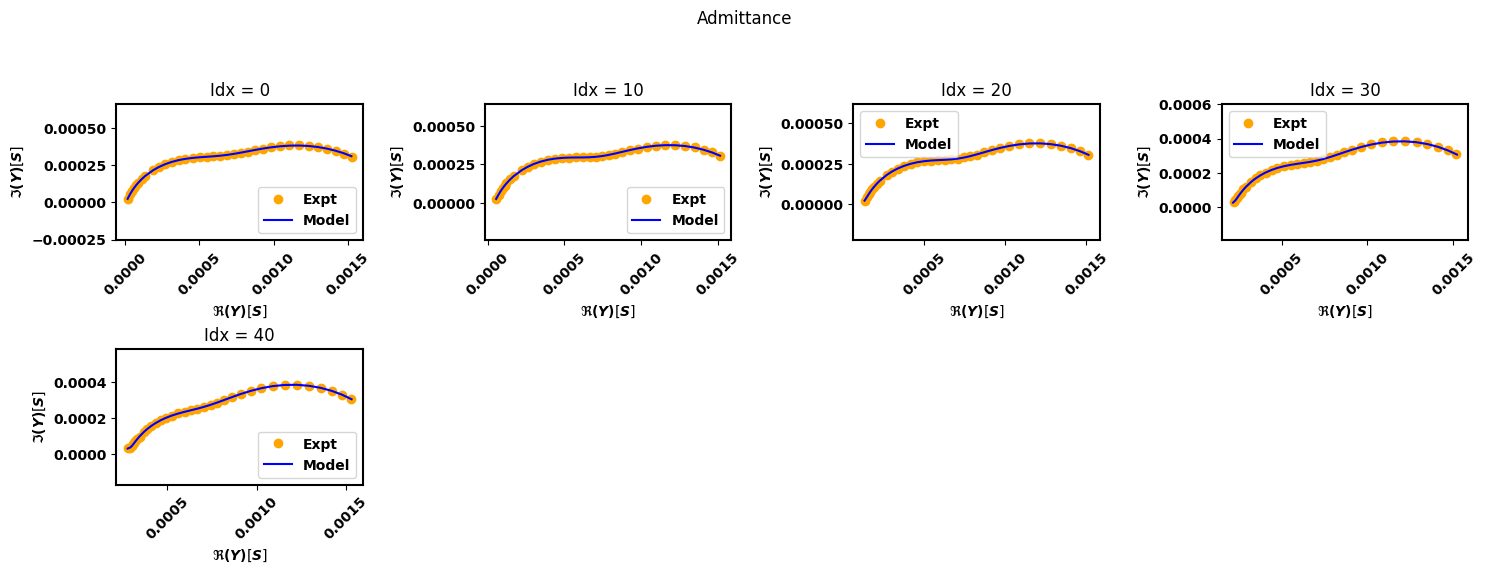

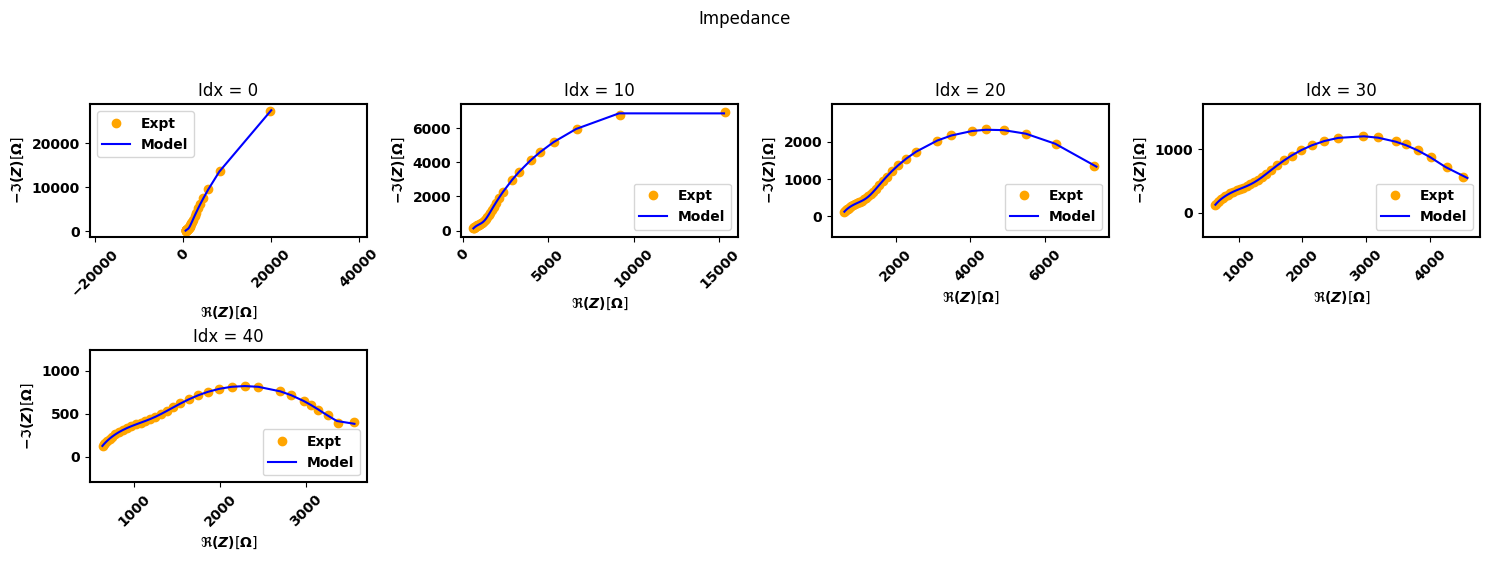

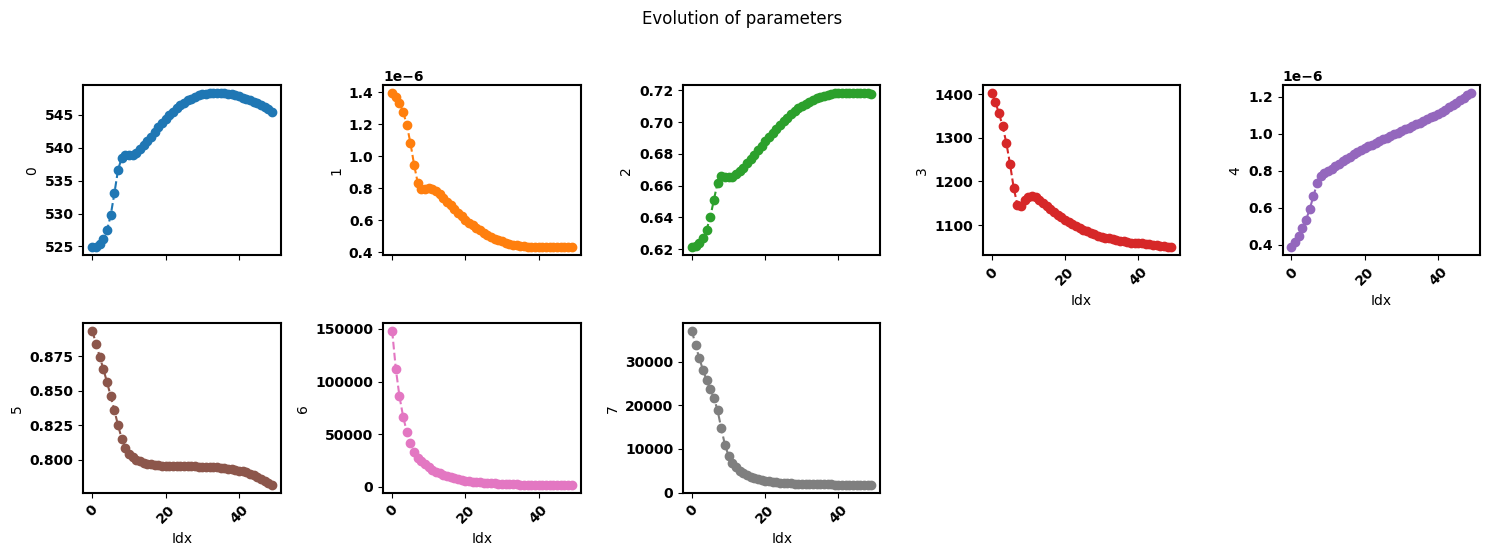

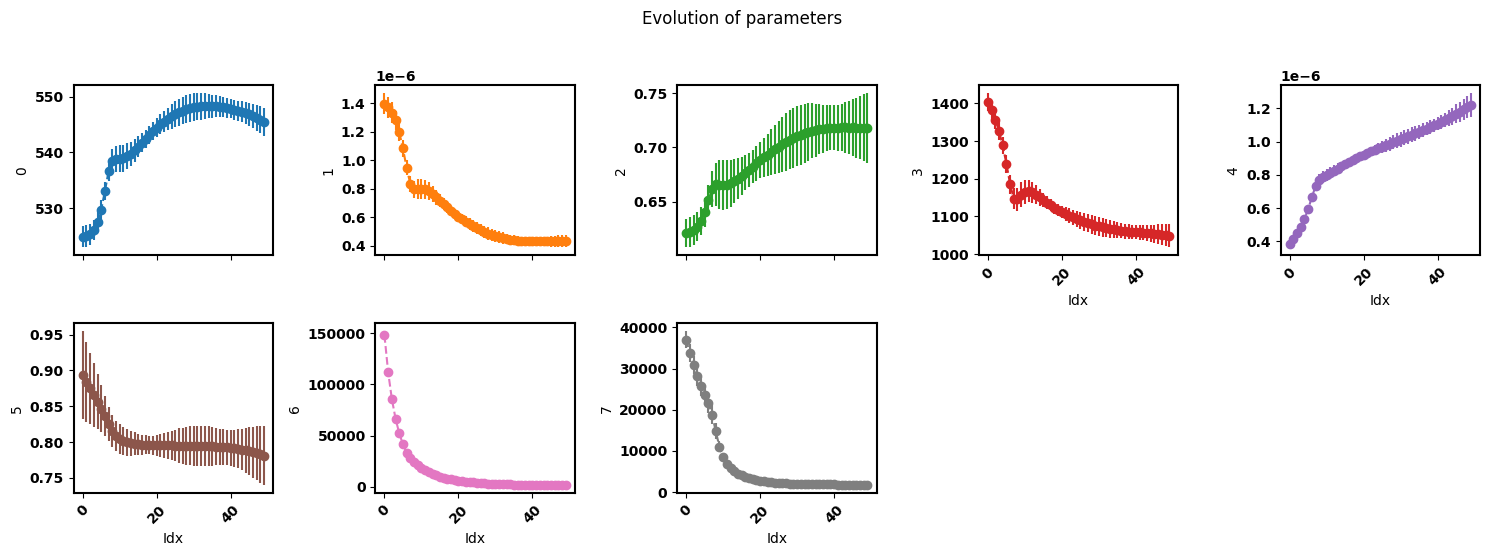

In [9]:
eis_her_simultaneous = pym.Multieis(p0, F_her, Y_her, bounds, smf_modulus, her, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous()
popt, perr, chisqr, chitot, AIC = eis_her.fit_sequential()
eis_her.plot_nyquist(10)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)

## 5. Repeating a single spectra (What to do when you have a single spectra to fit)

In [10]:
Y_her_single_spectra = Y_her[:, 41]
Y_her_single_spectra.shape
# torch.Size([35])

torch.Size([35])

In [11]:
Y_her_repeated = torch.tile(Y_her_single_spectra[:,None], (1, 10))
Y_her_repeated.shape
# torch.Size([35, 10])

torch.Size([35, 10])

In [12]:
smf = torch.full((len(p0),), torch.inf)
eis_her = pym.Multieis(p0, F_her, Y_her_repeated, bounds, smf, her, weight= 'modulus', immittance='admittance')
# popt, perr, chisqr, chitot, AIC = eis_her.fit_simultaneous()
popt, perr, chisqr, chitot, AIC = eis_her.fit_stochastic()
popt, perr, chisqr, chitot, AIC = eis_her.fit_sequential()
eis_her.plot_nyquist(2)
eis_her.plot_params()
eis_her.plot_params(show_errorbar=True)


Using initial
0: loss=9.370e-02
10000: loss=4.670e-04
20000: loss=3.162e-06
30000: loss=3.162e-06
40000: loss=3.163e-06
50000: loss=3.162e-06
60000: loss=3.163e-06
